# Introduction to Lagrangian Neural Network

by Abhay Shinde

In this tutorial, we will be working with Lagrangian Neural Networks (LNNs) to model the dynamics of a spring pendulum system. Unlike standard neural networks that simply try to fit observed trajectories, LNNs are designed to respect the underlying physical laws of motion by learning the system’s Lagrangian function directly.

LNNs are especially powerful when modeling systems where energy interactions between different degrees of freedom matter—like our spring pendulum, where both radial (spring extension) and angular (pendulum swing) dynamics are tightly coupled.

We will use DeepChem’s tools—such as TorchModel, NumpyDataset, and MultilayerPerceptron—together with some custom code to build and train LNN. The goal is to show how the model can learn the Lagrangian of the spring pendulum system and generate physically consistent trajectories using the Euler–Lagrange equations.

## Colab
This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/lnn_tutorial.ipynb)

# Euler Lagrangian Equation

In classical mechanics, a system’s motion can be described elegantly using the Lagrangian formulation.
Instead of focusing on forces, the Lagrangian approach works with energy — describing how a system evolves based on its kinetic and potential energy.

The Lagrangian, denoted by `L`, is defined as:

$$
L = T - V
$$
where T is the kinetic energy and V is the potential energy of the system.  

The dynamics are then derived from the Euler–Lagrange equation:
$$
\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q}_i} \right) - \frac{\partial L}{\partial q_i} = 0
$$

read more about this here - [Link](https://greydanus.github.io/2020/03/10/lagrangian-nns/)


In [2]:
import torch
import numpy as np
from scipy.integrate import odeint

In [3]:
def q2xy(ql):
  '''
  Polar coords to xy
  '''
  try:
      xy = np.zeros_like(ql)
      sin = np.sin
      cos = np.cos
  except:
      xy = torch.zeros_like(ql)
      sin = torch.sin
      cos = torch.cos

  xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
  xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
  return xy

def compute_accelerations(q, qt, g=10, k=10):
    '''
    q is array of genralise coords, [r, theta]
    qt is array of genralise coords, [rdt, thetadt]

    returns time derivative of q.
    '''
    qdtt = np.zeros_like(q)

    qdtt[:, 0] = q[:, 0]*qt[:, 1]**2 - g*(1-np.cos(q[:, 1])) - 2*k*(q[:, 0]-1)
    qdtt[:, 1] = (-g*np.sin(q[:, 1]) -2*qt[:, 0]*qt[:, 1])/q[:, 0]

    return qdtt

def solve_spring_pendulum_ode(q0, qt0, t,):

    x0 = np.append(q0, qt0)

    def f_anal(x, t):
        d = np.zeros_like(x)
        d[:2] = x[2:]
        d[2:] = np.squeeze(compute_accelerations(np.expand_dims(x[:2], axis=0), np.expand_dims(x[2:], axis=0)))
        # print(x, d)
        return d

    return odeint(f_anal, x0, t, rtol=1e-10, atol=1e-10)

def get_state_derivatives(x, t):
  d = np.zeros_like(x)
  d[:, :2] = x[:, 2:] # velocities [ x_dot, theta_dot ]
  d[:, 2:] = compute_accelerations(x[:, :2], x[:, 2:]) # accelerations [ x_ddot, theta_ddot ]
  return d

def get_dataset(t0=0, tlast=10, train_split=0.8):
    data = {'meta': locals()}

    timesteps = torch.tensor(np.linspace(t0, tlast, 1500)).float()
    q0 = np.array([1.1, 0.5])  # initial position
    qt0 = np.array([0.0, 0.0])  # initial velocity

    X = torch.tensor(solve_spring_pendulum_ode(q0, qt0, timesteps)).float()
    derivatives = torch.tensor(get_state_derivatives(X, timesteps)).float()

    # inputs and outputs
    data['x'] = X.numpy()
    data['dx'] = derivatives[:, 2:].numpy()

    # train/test split
    split_ix = int(len(data['x']) * train_split)
    split_data = {}
    for k in ['x', 'dx']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]

    data = split_data
    return data


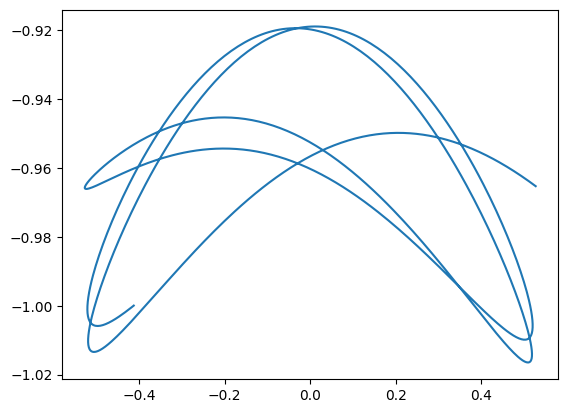

In [4]:
import matplotlib.pyplot as plt

q0 = np.array([1.1, 0.5])
qt0 = np.array([0.0, 0.0])
t = np.arange(0, 5, 0.005)
path = solve_spring_pendulum_ode(q0, qt0, t)
xy = q2xy(path)

plt.plot(xy[:, 0], xy[:, 1])

## Setup

In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

In [ ]:
from deepchem.data import NumpyDataset
from deepchem.models.torch_models.hnn import LNN, LNNModel

# loading dataset in NumpyDataset
data = get_dataset()
train_dataset = NumpyDataset(X=data['x'], y=data['dx'])
test_dataset = NumpyDataset(X=data['test_x'], y=data['test_dx'])

# creating model instance
model = LNNModel(n_dof=2, d_hidden=(64, 64))

# training for 100 epochs
model.fit(train_dataset, nb_epoch=1000)

/usr/local/lib/python3.12/dist-packages/deepchem/models/torch_models/torch_model.py:455: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  avg_loss = float(avg_loss) / averaged_batches


0.005925791263580322

In [6]:
predictions = model.predict(test_dataset)

print(test_dataset.y[:1])
print(predictions[:1])

[[ 1.54082   -3.7345955]]
[[ 1.5011837 -3.677598 ]]


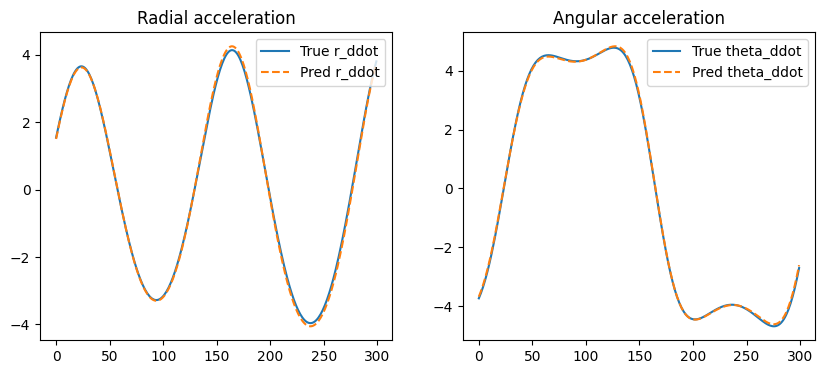

In [7]:
y_true = test_dataset.y
y_pred = predictions

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(y_true[:,0], label="True r_ddot")
plt.plot(y_pred[:,0], '--', label="Pred r_ddot")
plt.legend()
plt.title("Radial acceleration")

plt.subplot(1,2,2)
plt.plot(y_true[:,1], label="True theta_ddot")
plt.plot(y_pred[:,1], '--', label="Pred theta_ddot")
plt.legend()
plt.title("Angular acceleration")
plt.show()


/tmp/ipython-input-2884541391.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([test_dataset.y.flatten(), predictions.flatten()],


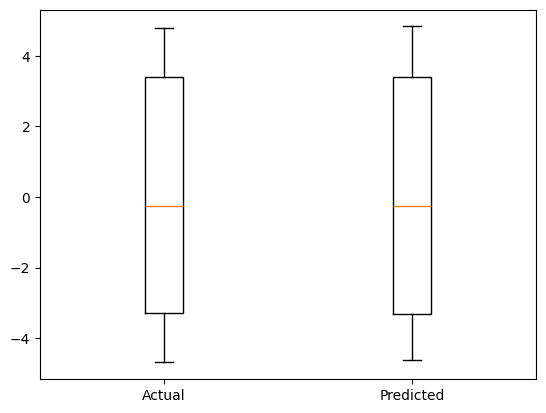

In [8]:
plt.boxplot([test_dataset.y.flatten(), predictions.flatten()],
            labels=['Actual', 'Predicted'])
plt.show()

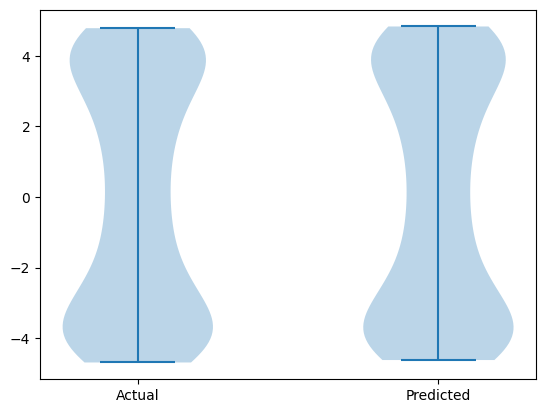

In [9]:
plt.violinplot([test_dataset.y.flatten(), predictions.flatten()])
plt.xticks([1, 2], ['Actual', 'Predicted'])
plt.show()

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!



In [ ]:
@manual{Intro10,
 title={Introduction to Lagrangian Neural Networks},
 organization={DeepChem},
 author={Abhay Shinde},
 howpublished = {\url{https://github.com/deepchem/deepchem/tree/master/examples/tutorials}},
 year={2025},
}